# Introduction
<br/>

해당 스크립트에서는 Multi Layer Perceptron이라고 불리는 기본적인 인공 신경망을 Python 라이브러리인 numpy를 이용하여 구현한 스크립트입니다.

해당 스크립트는 다음과 같으신 분을 위해서 쓰여졌습니다.

1. Python 기초를 아시는 분
2. 기본적인 딥러닝의 이론에 대해서 이해가 있으신분. 
3. Tensorflow나 Torch등 기본적인 프레임워크로도 구현을 해봤는데, 내부 동작은 어떻게 돌아가는지에 대해서 궁금하신 분

<br/>
만약에 해당 스크립트가 너무 어렵게 느껴지시거나 이론을 조금 더 알고 싶으시다면 아래의 링크에서 딥러닝의 기초에 대해서 배울 수 있으니, 먼저 기본적인 딥러닝에 대해서 학습하고 오시기를 권장해드립니다

<br/>
[<font size="3">[1]. 모두의 딥러닝 (무료/국문)](https://www.youtube.com/watch?v=BS6O0zOGX4E&list=PLlMkM4tgfjnLSOjrEJN31gZATbcj_MpUm)
<br/><br/>
[<font size="3">[2]. 헬로 딥러닝 (무료/국문)](https://www.youtube.com/watch?v=yWySw4EfSJc&t=424s)
<br/><br/>
[<font size="3">[3]. 코세라, Deep Learning Specialization (유료/영문)](https://www.coursera.org/specializations/deep-learning?utm_source=gg&utm_medium=sem&campaignid=917423980&adgroupid=46295378339&device=c&keyword=coursera%20deep%20learning&matchtype=p&network=g&devicemodel=&adpostion=1t1&creativeid=217989182387&hide_mobile_promo&gclid=EAIaIQobChMI_cnop7HU1wIVzgMqCh2CdAQiEAAYASAAEgKbcfD_BwE)
<br/><br/><br/><br/>

# Building Deep Neural Network :: Multi Layer Perceptron


<br/>
시작하기 앞서서 해당 스크립트의 핵심은 다음과 같이 구현되어 있습니다.

- 기본적인 인공신경망(Multi Layer Perceptron)에 대해서 설명합니다.


- <전파 알고리즘(Forward Operation)> / 역전파 알고리즘(BackPropagation) / 활성화함수(Activation function) / 분류기(Softamx) / 에러함수(MSE, Cross-Entropy Error) 에 대한 작은 모듈들을 만듭니다.


- 해당 모듈을 만들고나면, 이를 연결하여 하나의 인공신경망을 만듭니다.


- 이에 대한 결과를 확인합니다.
<br/><br/><br/>

**<font size="5">목차**

**<font size="3">1. MNIST DataSet 설명 및 데이터 로드**<br/>

**<font size="3">2. Multi-Layer Perceptron Overview**
    
**<font size="3">3. 전파 알고리즘(Forward Operation) 개념 :: 기초**
    
**<font size="3">4. 전파 알고리즘(Forward Operation) 개념 :: 행렬**

**<font color="#BDBDBD"><font size="3">5. TODO 활성화 함수(Activation Function) 개념**

**<font size="3">6. 비용 함수(Cost Function) 개념 :: 분류 오차/MSE/CEE**

**<font color="#BDBDBD"><font size="3">7. TODO 경사 하강 알고리즘(Gradient Descent) 개념 **
    
**<font color="#BDBDBD"><font size="3">8. TODO 역 전파 알고리즘(Backpropagation) 개념 **
    
**<font size="3">9. 가중치(weights) 생성 및 초기화 :: 단일 layer (Code)**

**<font size="3">10. 가중치(weights) 생성 및 초기화 :: 다중 layer (Code)**

**<font size="3">11. 전파 알고리즘(Forward Operation) :: 단일 layer (Code)**

**<font size="3">12. 활성화 함수(Activation Function)와 활성화 함수의 미분 (Code)**

**<font size="3">13. 다중 전파 알고리즘(Forward Operation) :: 다중 layer (Code)**

**<font size="3">14. 비용 함수(Cost Function) (Code)**
    
**<font color="#BDBDBD"><font size="3">15. TODO 경사 하강 알고리즘(Gradient Descent) (Code)**
    
**<font color="#BDBDBD"><font size="3">16. TODO 역 전파 알고리즘(Backpropagation) (Code)**
    
**<font color="#BDBDBD"><font size="3">17. TODO MNIST 학습 :: numpy 기반 (Code)**
    
**<font color="#BDBDBD"><font size="3">17. TODO MNIST 학습 :: tensorflow 기반 (Code)**

<br/>
<br/>*<font color="red">해당 스크립트는 코세라의 Deep Learning Specialization의 코드를 기반으로 했음을 알려드립니다*
<br/><br/><br/><br/>

## 1 - MNIST Data Load 

먼저, 예제 데이터를 입력으로 사용하기 위해서 MNIST 데이터를 로드하겠습니다.

MNIST 데이터는 Figure 1과 같이 사람들의 다양한 손글씨 이미지를 대량으로 모아놓은 데이터입니다.
<br/><br/>
<img src="images/14481-mnist-dataset.png" style="width:650px;height:300px;">
<caption><center> <u>Figure 1</u>: MNIST DataSet </center></caption>
<br/><br/>

일반적으로 모든 이미지는 데이터로 변환할 수 있는데, 아래의 Figure 2와 같이 하얀색에 가까울 수록 값이 0에 가까워지고
검은색에 가까워질 수록 값이 1에 가까워지는 형태로 표현할 수 있습니다.
<br/><br/>
그림과 같이 MNIST 데이터는 다양한 손글씨 데이터를 width=28, height=28의 흑백이미지(검은색과 하얀색으로 이루어진)의 데이터 집합이라고 보시면 됩니다.

<br/><br/>
*<font color="red">이해를 위해서 그림과 일치하게 설명한 것일 뿐입니다. 실제로는 하얀색에 가까울 수록 값은 "1", 검은색에 가까울 수록 값은 "0"에 근접합니다.*<br/><br/>

<br/>
<img src="images/d4e5709ebb4ba940126de44c76ca71b0.png" style="width:650px;height:300px;">
<caption><center> <u>Figure 2</u>: Image Data </center></caption>


MNIST 데이터의 특징은 다음과 같습니다.

- 이미지의 width와 height가 모두 28입니다.


- 흑백 이미지입니다.


- 따라서 MNIST 데이터의 갯수는 $28x28x1=784$이 됩니다.<br/>
*<font color="red">이 또한 이해를 위해서 간략하게 설명한 것입니다. 실은 데이터의 차원이라고 말하는 게 더 옳은 표현입니다.*<br/><br/>



### 1 - 1 MNIST Data Load 

<br/>
**Note**: 일반적으로 이미지 데이터를 읽어들이게되면 numpy의 dtype("uint8")으로 저장이 됩니다. uint8은 0~255 사이의 값으로 표현되며, 이를 "0"과 "1"사이의 데이터로 정규화하기 위해서 255로 나누어주는 과정을 거칩니다.
<br/><br/>

In [3]:
import numpy as np
import gzip
import struct
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 20)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# MNIST Data Load
def read_data(label_path, image_path):
    with gzip.open(label_path) as flbl:
        _, _ = struct.unpack(">II", flbl.read(8))
        label = np.fromstring(flbl.read(), dtype=np.int8)
    with gzip.open(image_path, 'rb') as fimg:
        _, _, rows, cols = struct.unpack(">IIII", fimg.read(16))
        image = np.fromstring(fimg.read(), dtype=np.uint8).reshape(len(label), rows, cols)
    return (label, image)

In [3]:
path = "data/"
(train_label, train_img) = read_data(path+'train-labels-idx1-ubyte.gz', path+'train-images-idx3-ubyte.gz')
(val_label, val_img) = read_data(path+'t10k-labels-idx1-ubyte.gz', path+'t10k-images-idx3-ubyte.gz')

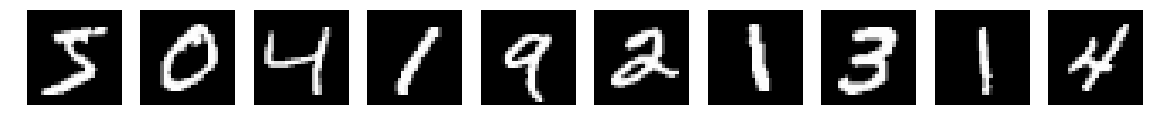

In [4]:
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(train_img[i], cmap='Greys_r')
    plt.axis('off')

plt.show()

train_label = train_label.astype(np.int64)
train_img = train_img.astype(np.float32) / 255
val_label = val_label.astype(np.int64)
val_img = val_img.astype(np.float32) / 255

<br/><br/>
## 2 - Multi Layer Perceptron :: Overview

MLP(Multi Layer Perceptron :: 이제부터 편의상 MLP라고 줄여서 이야기하도록 하겠습니다)의 순서는 다음과 같습니다.

1.실행 :: 학습이 완료되었을 경우


- 데이터 입력 
- 전파 알고리즘 (Forward Operation)
<br/>

<img src="images/MLP_test.png" style="width:650px;height:200px;">
<caption><center> <u>Figure 3</u>: MLP Test</center></caption>


2.학습 


- 데이터 입력
- 전파 알고리즘 (Forward Operation)
- 비용 함수 계산 (Cost Calculation)
- 역전파 알고리즘 (Backpropagation)
- 위의 4가지 순서를 반복 (Iteration)

<img src="images/MLP_train.png" style="width:650px;height:250px;">
<caption><center> <u>Figure 4</u>: MLP Train</center></caption>

<br/><br/>
Figure 5는 그림에서 위의 알고리즘이 어디에 해당하는지 표시한 그림입니다.

<img src="images/MLP_train_detail.png" style="width:850px;height:400px;">
<caption><center> <u>Figure 5</u>: MLP Train Detail</center></caption>

### 2-1 전파 알고리즘(Forward Operation) :: 기본 컨셉 (basic concept)

<br/>
이제 이 MLP에서 한개의 레이어를 자세히 살펴보도록 하겠습니다.

<br/><br/>

<img src="images/Multilayer-Perceptron-Forward-Propagation.png" style="width:650px;height:550px;">
<caption><center> <u>Figure 6</u>: 1-Layer MLP </center></caption>


**<font size="3"><font color="red">Note**: <br/><br/>
*$l1,l2$* : 각각 하나의 입력데이터를 의미합니다.

*화살표의 숫자* : 가중치 값을 의미합니다. 해당 스크립트에서는 $l1$에서 $H1$으로 가는 가중치를 $W_{l_{1}}^{H_{1}}$이라고 하겠습니다

**$H1, H2, H3$** : 각각의 뉴런(Hidden Unit)입니다.

**$O1, O2$** : 각각의 출력 뉴런을 의미합니다

*활성화 함수(Activation function)* : 해당 그림에는 표기되어있지 않으나, 활성화 함수는 `Sigmoid`입니다.<br/>
`Sigmoid`함수는 추후에 설명하겠으나, 흐름을 따라가기 위해서 기본적인 수식이 이렇다는 것만 알아두고 넘어가겠습니다.<br/>

$$Sigmoid = \frac{1}{1+e^{-x}}$$


<br/><br/>
이제부터 전파 알고리즘이 어떻게 진행되는지, 차례차레 풀어보도록 하겠습니다.

기본적으로 인공 신경망의 연산은 다음과 같은 수식을 띕니다.

<br/>
$$Y = \sigma(WX+b)$$

<br/>
**<font size="3"><font color="red">Note**<br/>

수식이 어렵게 느껴지실 수도 있지만, 정말 간단합니다.

$W$ : 가중치를 의미합니다.

$X$ : 입력값을 의미합니다.

$b$ : 편향(bias)라고 불리는 숫자(상수)입니다.

$\sigma$ : 활성화 함수(Acitvation function)을 의미합니다

$Y$ : 출력값입니다.

이를 가지고 말로 풀어서 써보자면, 
- 입력과 가중치를 곱합니다.
- 그 결과에 어떠한 숫자(편향)를 더합니다.
- 그 결과를 활성화 함수에 넣어줍니다.
- 활성화 함수의 결과가 출력값이 됩니다.


<br/><br/><br/>

**<font size="4">1. $H1, H2, H3$ 뉴런 Input값과 Output값 유도**
<br/><br/>
그럼 이제 $H1$의 결과가 어떻게 나오게 됬는지 $Y = \sigma(WX+b)$을 통해서 확인해보겠습니다.
    

- $Z = (l1 \times 0.3) + (l2 \times 0.2) + 0 = (10\times0.3) + (20\times0.2) + 0 = 7$ :: 여기에서 bias는 없으므로 0으로 대체합니다.


- $Sigmoid(Z) = \frac{1}{1+e^{-7}} = 0.999$
<br/><br/>

이런 형태로 $H2, H3$ 그리고 더 나아가서 $O1, O2$값도 똑같은 방법으로 구할 수 있습니다.

<br/><br/><br/>

### 2-2 Forward Operation :: matrix concept
<br/>
지금까지 기본적인 $Y = \sigma(WX+b)$를 이용해서, 어떻게 MLP의 전파 알고리즘이 진행되는지 확인하였습니다

이번에는 이를 모두 하나의 행렬로 묶어서 표현하고 연산하는 방법에 대해서 소개하겠습니다.

Figure 6의 값들은 모두 행렬로 표현할 수 있고, 행렬 연산으로 수행할 수 있습니다.

먼저 입력에 대해서 먼저 보면 $l1 = 10,  l2 = 20$ 입니다. 

<br/>
이를 행렬로 표현하면 다음과 같습니다.

$Input = \begin{bmatrix}
    10 & 20
\end{bmatrix}\;\;\; $

<br/><br/>
Input layer와 Hidden Layer 사이의 가중치들을 행렬로 표현하면 다음과 같습니다.

$W_{input}^{hidden} = \begin{bmatrix}
    0.3  & -0.1  &  1.1 \\
    0.2  & -0.2  &  -0.5
\end{bmatrix}\;\;\; $

<br/><br/>
Hidden Layer와 Output layer 사이의 가중치들을 행렬로 표현하면 다음과 같습니다.

$W_{hidden}^{out} = \begin{bmatrix}
    1.1  &  0.4 \\
    0.5  &  0.3 \\
    0.7  &  0.2
\end{bmatrix}\;\;\; $

이렇게 데이터들을 행렬로 표현하고, 위와 똑같이 $Y = \sigma(WX+b)$를 적용하면 더 간편하게 표현할 수 있습니다.

<br/><br/><br/>
**<font size="3"><font color="red">Note**<br/>
    
여기서의 곱셈 연산은 행렬곱셈 연산을 의미합니다.<br/>
행렬 곱셈 연산은 다음 Figure 7와 같은 방식으로 이루어집니다.
<img src="images/animation03.gif" style="width:650px;height:300px;">
<caption><center> <u>Figure 7</u>: Matrix Multiply</center></caption>


    
<br/><br/>

**<font size="4">1. $H1, H2, H3$ 뉴런값들을 행렬 연산으로 유도** <br/>
    
계속 이야기했듯이 행렬표현으로 변경해도 전파 알고리즘 수식인 $Y = \sigma(WX+b)$가 똑같이 적용된다고 말씀드렸었습니다.

그럼 지금부터 행렬 연산을 기반으로 $H1, H2, H3$ 뉴런값을 한번에 구해보도록 하겠습니다.


- $Z=WX+b$<br/><br/>
$Z_{hidden} = \begin{bmatrix}H1&H2&H3\end{bmatrix} = \begin{bmatrix}10&20\end{bmatrix}\times\begin{bmatrix}0.3&-0.1&1.1\\0.2&-0.2&-0.5\end{bmatrix} + \begin{bmatrix}0&0&0\end{bmatrix} = \begin{bmatrix}7&-5&1\end{bmatrix}$<br/><br/><br/>

- $Y_{hidden} = Sigmoid(Z_{hidden})$<br/><br/>
$ Y= \begin{bmatrix}Sigmoid(H1)&Sigmoid(H2)&Sigmoid(H3)\end{bmatrix} = \begin{bmatrix}\frac{1}{1+e^{-7}}&\frac{1}{1+e^{5}}&\frac{1}{1+e^{-1}}\end{bmatrix} = \begin{bmatrix}0.999&0.007&0.731\end{bmatrix}$<br/>

<br/><br/>

이런 방식으로 똑같이 $O1, O2$도 구할 수 있습니다.
<br/><br/>

### 2-3 Cost Function
<br/><br/>
지금까지 MLP의 전파 알고리즘(Forward Operation)의 개념을 확인하였습니다. 

이렇게 MLP의 전파 알고리즘을 타고 최종적으로 출력된 값은 중요한 의미를 갖습니다.

예를 들어 어떠한 이미지를 입력데이터로 인공신경망에게 넣었을 때, 출력값은 이게 **개**인지 **고양이**인지에 대한 출력으로 볼 수 있습니다.


<br/><br/>
만약에 우리가 가중치값들을 임의로 준 상태에서 입력에 고양이 이미지를 넣는다면 

출력값은 분명 정확히 이게 개인지 고양인지 출력값을 낼 수 없을 것입니다.
<br/><br/>

그렇기 때문에 우리는 인공 신경망에게 입력 데이터를 주면서 이 데이터는 **고양이**야 라고 알려주어야 하며, 인공 신경망은 이를 통해서

내가 낸 출력값과 정답이 얼만큼 차이가 나는지를 계산해서 스스로 가중치의 값을 변화하는 과정을 거치게 됩니다.

이러한 학습 방법을 딥러닝에서는 지도 학습(Supervised Learning)이라고 부릅니다.


<img src="images/cat-dog-flow-horizontal.gif" style="width:650px;height:300px;">
<caption><center> <u>Figure 8</u>: Cat and Dog Classifier with Neural Network</center></caption>

<br/><br/>
그러면 임의로 가중치의 값이 주어진 인공신경망이 입력데이터를 받아서 출력값을 냈을 때, 정답과 출력값이 다른지는 어떻게 알며,

얼마나 틀렸는지에 대해서는 어떻게 알까요?

이러한 부분에 대해서 중요한 역활을 하는 것이 비용 함수(Cost Function)이 됩니다.

그럼 이번에는 인공 신경망에서 쓰이는 비용 함수에 대해서 본격적으로 이야기 해보도록 하겠습니다.

<br/><br/><br/>
**<font size="3">Cross-Entropy Error** <br/><br/>

먼저 해당 스크립트에서는 비용 함수(Cost Function)를 Cross-Entropy Error를 사용합니다.

Cross-Entory Error에 대한 수식은 다음과 같습니다.

이해가 어려우시다면 뒤에 설명이 나오니 수식이 이렇게 생겼다는 것만 확인하시고, 넘어가시면 됩니다.

$$ J = -\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{7}$$

**<font size="3">오차(Error)** <br/><br/>
    
만약에 인공 신경망이 다음과 같은 2가지 결과를 주었다고 가정해 보겠습니다.

우리는 여기서 인공 신경망의 정확도가 몇이고, 얼마나 틀렸는지를 확인해야한다고 합시다
<br/><br/><br/>

**1-th network**
<table style="width:50%", title="1-th network">
  <tr>
    <td> **계산결과** </td>
    <td> **라벨(A/B/C)** </td>
    <td> **Correct?** </td>
  </tr>
  <tr>
    <td> 0.3  0.3  0.4 </td>
    <td > 0  0  1 (A) </td> 
    <td > yes </td> 
  </tr>
  <tr>
    <td> 0.3  0.4  0.3 </td>
    <td > 0  1  0 (B) </td> 
    <td > yes </td> 
  </tr>
  <tr>
    <td> 0.1  0.2  0.7 </td>
    <td > 1  0  0 (C) </td> 
    <td > no </td> 
  </tr>
</table>
**2-th network**
<table style="width:50%", title="2-th network">
  <tr>
    <td> **계산결과** </td>
    <td> **라벨(A/B/C)** </td>
    <td> **Correct?** </td>
  </tr>
  <tr>
    <td> 0.1  0.2  0.7 </td>
    <td > 0  0  1 (A) </td> 
    <td > yes </td> 
  </tr>
  <tr>
    <td> 0.1  0.7  0.2 </td>
    <td > 0  1  0 (B) </td> 
    <td > yes </td> 
  </tr>
  <tr>
    <td> 0.3  0.4  0.3 </td>
    <td > 1  0  0 (C) </td> 
    <td > no </td> 
  </tr>
</table>


<br/>
위 결과에 대해서 3가지 방법(**분류 오차/MSE(Mean Squared Error)/CEE(Cross-Entroy Error)** 오차를 계산해보겠습니다.
<br/><br/><br/>


**1. 분류 오차**

분류 오차는 인공 신경망의 출력값들이 정답과 비교했을 때, 몇개를 맞췄고 몇개를 못맞췄는지에 대해서 비교해서

인공신경망의 정확도를 측정하는데 쓰입니다.
<br/><br/><br/>

- *1-th network*:
 - 분류오차 -> *(3개의 샘플 중에 1개가 라벨과 일치하지 않으므로)*$$\frac{1}{3} = 0.33$$ <br/><br/><br/> 
 - 분류 정확도 -> $$\frac{2}{3} = 0.67$$
<br/><br/>

- *2-th network*:
 - 분류오차 -> *(3개의 샘플 중에 1개가 라벨과 일치하지 않으므로)* $$\frac{1}{3} = 0.33$$ <br/><br/><br/>
 - 분류 정확도 -> $$\frac{2}{3} = 0.67$$

두 오차에 대해서 비교해보면, **결과는 같지만**, 2-th 네트워크의 첫 두 샘플은 1-th 네트워크보다 조금 더 확실히 맞추었고, 세번째 샘플은 아깝게 틀렸다는 것을 확인할 수 있습니다.

이러한 결과를 보았을 때, **단순 분류 오차**의 계산은 틀린 개수에 대한 결과만 줄 뿐 **정답과 비교해서 얼마나 많이 틀렸는지 얼마나 정확하게 맞았는지** 그 정도에 대한 값을 제공하지 않습니다
<br/><br/><br/><br/>
**2. MSE(Mean Squared Error)**
<br/><br/><br/>
MSE(Mean Squared Error)는 정답과 내가 얼마나 멀리 떨어져있는지에 대해서 정의하는 함수입니다.

쉽게 이야기하기 위해서 내가 집에 가고 싶은데, 지금 위치에서 집까지의 거리를 확인해서 

내가 집까지 가기 위한 거리값을 오차값으로 잡는 것을 MSE로 이해하면됩니다.

MSE의 수식은 다음과 같습니다.

<br/><br/>
$$J = \frac{1}{n}\sum\limits_{i=1}^{n}{(\hat{Y_{i}} - Y_{i})^{2}}$$

<img src="images/scatter_plot.gif" style="width:400px;height:300px;">
<caption><center> <u>Figure 9</u>: Mean Squared Error</center></caption>

<br/>
- *1-th network*:<br/><br/>
 - 분류오차 -> $(0.3-0)^{2} + (0.3-0)^{2} + (0.4-1)^{2} = 0.54$ (나머지 2개의 샘플에 대해서는 생략..)<br/><br/>
 - 분류 정확도 -> $\frac{(0.54 + 0.54 + 1.34)}{3} = 0.81$<br/><br/>
<br/><br/>

- *2-th network*:<br/><br/>
 - 분류오차 -> (생략...)<br/><br/>
 - 분류 정확도 -> $\frac{(0.14 + 0.14 + 0.74)}{3} = 0.34$<br/><br/>

<br/><br/>
**3. Cross-entropy Error**


CEE(Cross-Entropy Error)는 내 출력값과 정답값이 얼마나 틀렸는지도 확인하고, 정답이 아닌 부분에 대해서도 이걸 정답으로

출력했다면, 이를 같이 반영하는 방법입니다.

<br/><br/>
수식은 다음과 같습니다. 

<br/>
$$J = -\frac{1}{m}\sum\limits_{i = 1}^{m}(\hat{Y_{i}}\log\left(Y_{i}\right) + (1-\hat{Y_{i}})\log\left(1- Y_{i}\right))$$

<br/>
- *1-th network*:<br/><br/>

 - 분류오차 -> (나머지 2개의 샘플에 대해서는 생략..)<br/><br/>$ -((0\times\log\left(0.3\right) + (1-0)\times\log\left(1-0.3\right)) + 0\times\log\left(0.3\right) + (1-0)\times\log\left(1-0.3\right) + 1\times\log\left(0.4\right) + (1-1)\times\log\left(1-0.4\right))$<br/><br/>
 = $(-0.356)+(-0.356)+(-0.916) = -1.628$<br/><br/>
 
 - 분류 정확도 -> <br/><br/>
 $\frac{-(-2.472 + -3.723 + -1.628)}{3} = 2.607$<br/><br/>
<br/><br/>

- *2-th network*:<br/><br/>
 - 분류오차 -> (생략...)<br/><br/>
 - 분류 정확도 -> $\frac{-(-0.684 + -0.684 + -2.066)}{3} = 1.144$<br/><br/>
 
 
<br/><br/>
결과에서 볼 수 있듯이 MSE는 틀린 샘플에 더 집중하는 특성을 갖습니다.

맞은 것과, 틀린 것에 똑같이 집중해야 하는데, 그렇지 않아 비용 함수로 정의할 때, 부적절하다고 할 수 있습니다.

따라서, 해당 스크립트의 비용 함수는 Cross-entory Error를 사용합니다.

<br/><br/><br/><br/>

## 2 - Forward Operation

1. 먼저 입력 데이터의 차원에 맞게, 가중치 행렬을 생성하고 초기화합니다.
2. 초기화된 Weights와 bias를 입력 데이터와 Linear 연산을 통해서 Weights Sum을 진행합니다.
3. 그 이후, ACTIVATION (Sigmoid, ReLU etc)를 이용해서 최종 출력을 얻습니다.


<img src="images/perceptron.png" style="width:650px;height:300px;">
<caption><center> <u>Figure 1</u>: Forward Operation. <br> The model can be summarized as: ***[INPUT -> LINEAR -> ACTIVATION]***</center></caption>

<br/>
위의 그림을 수식으로 일반화하면, 아래와 같습니다
<br/><br/>

<table style="width:100%">


    <tr>
        <td>  </td> 
        <td> **Shape of W** </td> 
        <td> **Shape of b**  </td> 
        <td> **Activation** </td>
        <td> **Shape of Activation** </td> 
    <tr>
    
    <tr>
        <td> **Layer 1** </td> 
        <td> $(n^{[1]},12288)$ </td> 
        <td> $(n^{[1]},1)$ </td> 
        <td> $Z^{[1]} = W^{[1]}  X + b^{[1]} $ </td> 
        
        <td> $(n^{[1]},209)$ </td> 
    <tr>
    
    <tr>
        <td> **Layer 2** </td> 
        <td> $(n^{[2]}, n^{[1]})$  </td> 
        <td> $(n^{[2]},1)$ </td> 
        <td>$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$ </td> 
        <td> $(n^{[2]}, 209)$ </td> 
    <tr>
   
       <tr>
        <td> $\vdots$ </td> 
        <td> $\vdots$  </td> 
        <td> $\vdots$  </td> 
        <td> $\vdots$</td> 
        <td> $\vdots$  </td> 
    <tr>
    
   <tr>
        <td> **Layer L-1** </td> 
        <td> $(n^{[L-1]}, n^{[L-2]})$ </td> 
        <td> $(n^{[L-1]}, 1)$  </td> 
        <td>$Z^{[L-1]} =  W^{[L-1]} A^{[L-2]} + b^{[L-1]}$ </td> 
        <td> $(n^{[L-1]}, 209)$ </td> 
    <tr>
    
    
   <tr>
        <td> **Layer L** </td> 
        <td> $(n^{[L]}, n^{[L-1]})$ </td> 
        <td> $(n^{[L]}, 1)$ </td>
        <td> $Z^{[L]} =  W^{[L]} A^{[L-1]} + b^{[L]}$</td>
        <td> $(n^{[L]}, 209)$  </td> 
    <tr>

</table>

Remember that when we compute $W X + b$ in python, it carries out broadcasting. For example, if: 

$$ W = \begin{bmatrix}
    j  & k  & l\\
    m  & n & o \\
    p  & q & r 
\end{bmatrix}\;\;\; X = \begin{bmatrix}
    a  & b  & c\\
    d  & e & f \\
    g  & h & i 
\end{bmatrix} \;\;\; b =\begin{bmatrix}
    s  \\
    t  \\
    u
\end{bmatrix}\tag{2}$$

Then $WX + b$ will be:

$$ WX + b = \begin{bmatrix}
    (ja + kd + lg) + s  & (jb + ke + lh) + s  & (jc + kf + li)+ s\\
    (ma + nd + og) + t & (mb + ne + oh) + t & (mc + nf + oi) + t\\
    (pa + qd + rg) + u & (pb + qe + rh) + u & (pc + qf + ri)+ u
\end{bmatrix}\tag{3}  $$

### 2-1. Initialization

- 데이터 차원에 맞게 가중치 행렬을 생성하고 초기화합니다.
- 일반적으로 weights는 난수로, bias는 0으로 초기화합니다.

In [35]:
# GRADED FUNCTION: initialize_parameters

def basic_initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    parameters -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(1)
    
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros(shape=(n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros(shape=(n_y, 1))
    
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters    

In [36]:
parameters = basic_initialize_parameters(2,2,1)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 0.01624345 -0.00611756]
 [-0.00528172 -0.01072969]]
b1 = [[ 0.]
 [ 0.]]
W2 = [[ 0.00865408 -0.02301539]]
b2 = [[ 0.]]


**Expected output**:
       
<table style="width:80%">
  <tr>
    <td> **W1** </td>
    <td> [[ 0.01624345 -0.00611756]
 [-0.00528172 -0.01072969]] </td> 
  </tr>

  <tr>
    <td> **b1**</td>
    <td>[[ 0.]
 [ 0.]]</td> 
  </tr>
  
  <tr>
    <td>**W2**</td>
    <td> [[ 0.00865408 -0.02301539]]</td>
  </tr>
  
  <tr>
    <td> **b2** </td>
    <td> [[ 0.]] </td> 
  </tr>
  
</table>

In [50]:
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):    
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))        
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

In [40]:
parameters = initialize_parameters_deep([5,4,3])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 0.01788628  0.0043651   0.00096497 -0.01863493 -0.00277388]
 [-0.00354759 -0.00082741 -0.00627001 -0.00043818 -0.00477218]
 [-0.01313865  0.00884622  0.00881318  0.01709573  0.00050034]
 [-0.00404677 -0.0054536  -0.01546477  0.00982367 -0.01101068]]
b1 = [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]
W2 = [[-0.01185047 -0.0020565   0.01486148  0.00236716]
 [-0.01023785 -0.00712993  0.00625245 -0.00160513]
 [-0.00768836 -0.00230031  0.00745056  0.01976111]]
b2 = [[ 0.]
 [ 0.]
 [ 0.]]


**Expected output**:
       
<table style="width:80%">
  <tr>
    <td> **W1** </td>
    <td>[[ 0.01788628  0.0043651   0.00096497 -0.01863493 -0.00277388]
 [-0.00354759 -0.00082741 -0.00627001 -0.00043818 -0.00477218]
 [-0.01313865  0.00884622  0.00881318  0.01709573  0.00050034]
 [-0.00404677 -0.0054536  -0.01546477  0.00982367 -0.01101068]]</td> 
  </tr>
  
  <tr>
    <td>**b1** </td>
    <td>[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]</td> 
  </tr>
  
  <tr>
    <td>**W2** </td>
    <td>[[-0.01185047 -0.0020565   0.01486148  0.00236716]
 [-0.01023785 -0.00712993  0.00625245 -0.00160513]
 [-0.00768836 -0.00230031  0.00745056  0.01976111]]</td> 
  </tr>
  
  <tr>
    <td>**b2** </td>
    <td>[[ 0.]
 [ 0.]
 [ 0.]]</td> 
  </tr>
  
</table>

### 2-2. Linear Forward Module

Linear Forward Module은 아래와 같은 수식으로 일반화되어 계산됩니다.

$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}\tag{4}$$

where $A^{[0]} = X$. 
<br/>
<br/>

In [41]:
def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    Z = np.dot(W, A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [59]:
X = train_img[0]
print("X's dimensions : {}".format(X.shape), end="\n\n")

parameters = initialize_parameters_deep([28,28,1])
print("key of parameters : {}".format(parameters.keys()), end="\n\n")
A, W, b = X, parameters["W1"], parameters["b1"]
Z, linear_cache = linear_forward(X, W, b)

print("Z[0] = " + str(Z[0]))

X's dimensions : (28, 28)

key of parameters : dict_keys(['b2', 'W1', 'b1', 'W2'])

Z[0] = [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
  -4.94962319e-03  -8.56088005e-03  -7.01055263e-03   9.21223156e-04
  -1.40779296e-03   7.28034138e-04  -5.37452855e-05  -5.59312440e-03
  -5.34447205e-03   6.72926288e-03  -7.75971334e-03  -1.84216995e-02
  -2.45760235e-02  -4.69203890e-02  -3.32101138e-02  -2.23488248e-02
  -8.95088092e-03  -5.70976535e-03  -5.02796410e-03  -1.97450375e-03
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]


**Expected output**:
       
<table style="width:100%">
  <tr>
    <td> **Z[0]** </td>
    <td>[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
  -4.94962319e-03  -8.56088005e-03  -7.01055263e-03   9.21223156e-04
  -1.40779296e-03   7.28034138e-04  -5.37452855e-05  -5.59312440e-03
  -5.34447205e-03   6.72926288e-03  -7.75971334e-03  -1.84216995e-02
  -2.45760235e-02  -4.69203890e-02  -3.32101138e-02  -2.23488248e-02
  -8.95088092e-03  -5.70976535e-03  -5.02796410e-03  -1.97450375e-03
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]</td> 
  </tr>
</table>

### 2-3. Linear-Activateion Forward

이번 예제에서는 2가지 종류의 Activation function을 사용합니다.


- **Sigmoid**: $\sigma(Z) = \sigma(W A + b) = \frac{1}{ 1 + e^{-(W A + b)}}$. `sigmoid` 함수는 **2개**의 return 값을 갖습니다. : activation value "`a`", ""`Z`"를 포함하고 있는 `cache`" (Backpropagation때, 이를 사용합니다). 사용법은 다음과 같습니다: 
``` python
A, activation_cache = sigmoid(Z)
```

<img src="images/sigmoid.png" style="width:650px;height:300px;">
<caption><center> <u>Figure 2</u>: Sigmoid.</center></caption>

- **ReLU**: 수학적 공식은 다음과 같습니다. $A = ReLU(Z) = max(0, Z)$. `relu` 함수는 **2개**의 return값을 갖습니다. : the activation value "`A`", `Z`를 포함하고 있는"`cache`""" (Backpropagation때, 이를 사용합니다). 사용법은 다음과 같습니다:
``` python
A, activation_cache = relu(Z)
```
<img src="images/relu.jpeg" style="width:650px;height:300px;">
<caption><center> <u>Figure 3</u>: ReLU.</center></caption>

- **Derivative of Sigmoid**: <br/> $g'(Z) = \frac{ d }{ dz }\frac{ 1 }{ 1+e^{-z} } = \frac{1}{(1+e^-z)^2}(e^{-z}) = \frac{1}{1+e^{-z}}(1-\frac{1}{1+e^{-z}}) = g(z)(1-g(z))$<br/><br/>

- **Derivative of ReLU**: <br/> $g'(Z) = \max(0, Z)$

In [5]:
def derivative_sigmoid(Z):
    return (1/(1+np.exp(-Z)) * (1-1/(1+np.exp(-Z))))

def derivative_relu(Z):
    np.maximum(0, Z)

def sigmoid(Z):
    return 1/(1+np.exp(-Z)), derivative_sigmoid(Z)

def relu(Z):
    return np.maximum(0, Z), derivative_relu(Z)

ValueError: x and y must not be None

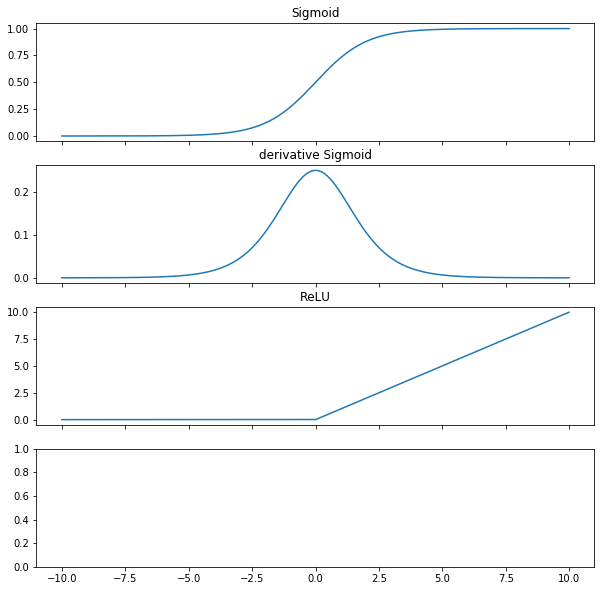

In [9]:
tmp = [round(i*0.01, 5) for i in range(-1000,1000)]
x = np.asarray(tmp)

f, axarr = plt.subplots(4, sharex=True)
f.set_figheight(10)
f.set_figwidth(10)
sig, derivate_sig = sigmoid(x)
ReLU, derivate_relu = relu(x)
axarr[0].plot(x, sig)
axarr[0].set_title("Sigmoid")
axarr[1].plot(x, derivate_sig)
axarr[1].set_title("derivative Sigmoid")
axarr[2].plot(x, ReLU)
axarr[2].set_title("ReLU")
axarr[3].plot(x, derivate_relu)
axarr[3].set_title("derivative ReLU")

In [78]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [80]:
X = train_img[0]
print("X's dimensions : {}".format(X.shape), end="\n\n")

parameters = initialize_parameters_deep([28,28,1])
print("key of parameters : {}".format(parameters.keys()), end="\n\n")
A_prev, W, b = X, parameters["W1"], parameters["b1"]

A, linear_activation_cache = linear_activation_forward(A_prev, W, b, activation="sigmoid")
print("With sigmoid: A[0] = " + str(A[0]))

A, linear_activation_cache = linear_activation_forward(A_prev, W, b, activation="relu")
print("With ReLU: A[0] = " + str(A[0]))

X's dimensions : (28, 28)

key of parameters : dict_keys(['b2', 'W1', 'b1', 'W2'])

With sigmoid: A[0] = [ 0.5         0.5         0.5         0.5         0.4987626   0.49785979
  0.49824737  0.50023031  0.49964805  0.50018201  0.49998656  0.49860172
  0.49866389  0.50168231  0.49806008  0.49539471  0.4938563   0.48827205
  0.49169823  0.49441303  0.49776229  0.49857256  0.49874301  0.49950637
  0.5         0.5         0.5         0.5       ]
With ReLU: A[0] = [ 0.          0.          0.          0.          0.          0.          0.
  0.00092122  0.          0.00072803  0.          0.          0.
  0.00672926  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.        ]


**Expected output**:
       
<table style="width:100%">
  <tr>
    <td> **With sigmoid: A[0] ** </td>
    <td > [ 0.5         0.5         0.5         0.5         0.4987626   0.49785979
  0.49824737  0.50023031  0.49964805  0.50018201  0.49998656  0.49860172
  0.49866389  0.50168231  0.49806008  0.49539471  0.4938563   0.48827205
  0.49169823  0.49441303  0.49776229  0.49857256  0.49874301  0.49950637
  0.5         0.5         0.5         0.5       ]</td> 
  </tr>
  <tr>
    <td> **With ReLU: A[0] ** </td>
    <td > [ 0.          0.          0.          0.          0.          0.          0.
  0.00092122  0.          0.00072803  0.          0.          0.
  0.00672926  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.        ]</td> 
  </tr>
</table>

### 2-4. L-Layer Model

이전까지 간단한 Forward Operation이 어떻게 구성되는지 확인하였습니다.<br/>
이러한 Forward Operation을 여러번 진행하게되면, 이것이 Deep Neural Network가 됩니다.<br/>

이번 코드에서는 SIGMOID ACTIVATION을 이용한 Muli Layer Forward Operation에 대해서 알아보겠습니다.

<img src="images/model_architecture_kiank.png" style="width:650px;height:300px;">
<caption><center> <u>Figure 4</u>: L-Layer Model.</center></caption>

**Note**: 이번 코드에서 다시 한번 Linear-Activation 수식을 언급하겠습니다.<br/>
$A^{[L]} = \sigma(Z^{[L]}) = \sigma(W^{[L]} A^{[L-1]} + b^{[L]})$. (마지막 출력의 경우 출력값의 표현을 `Yhat`이라고 합니다, i.e., 수식적으로 표현하면 다음과 같습니다. $\hat{Y}$.)

In [81]:
def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, 
                                             parameters['W' + str(l)], 
                                             parameters['b' + str(l)], 
                                             activation='relu')
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, 
                                          parameters['W' + str(L)], 
                                          parameters['b' + str(L)], 
                                          activation='sigmoid')
    caches.append(cache)
    
    assert(AL.shape == (1, X.shape[1]))
            
    return AL, caches

In [82]:
X, parameters = train_img[0], initialize_parameters_deep([28,28,1])
AL, caches = L_model_forward(X, parameters)
print("AL = " + str(AL))
print("Length of caches list = " + str(len(caches)))

AL = [[ 0.5         0.5         0.5         0.5         0.50000488  0.49999259
   0.49999292  0.50006658  0.50019038  0.50018837  0.5000768   0.50000425
   0.50000441  0.49996328  0.49990328  0.49989251  0.49988565  0.50000674
   0.49992422  0.49995059  0.49978186  0.49970537  0.4997401   0.49989355
   0.5         0.5         0.5         0.5       ]]
Length of caches list = 2


<table style="width:100%">
  <tr>
    <td> **AL** </td>
    <td > [[ 0.5         0.5         0.5         0.5         0.50000488  0.49999259
   0.49999292  0.50006658  0.50019038  0.50018837  0.5000768   0.50000425
   0.50000441  0.49996328  0.49990328  0.49989251  0.49988565  0.50000674
   0.49992422  0.49995059  0.49978186  0.49970537  0.4997401   0.49989355
   0.5         0.5         0.5         0.5       ]]</td> 
  </tr>
  <tr>
    <td> **Length of caches list ** </td>
    <td > 2</td> 
  </tr>
</table>

## 3 - Cost Function

지금까지 Muli Layer Forward Operation을 구현하였습니다.

이번엔 Forward Operation의 결과와 label 값을 통해서 나온 결과를 비교해서 비용함수를 정의하도록 하겠습니다.

**Exercise**: 여기서는 cross-entropy cost $J$를 계산합니다, 수식은 다음과 같습니다.: $$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{7}$$

**Why Cross-entropy Cost?**: MSE(Mean Squared Error)의 경우네는 틀린 샘플에 대해서 더 집중하는 특징을 갖습니다. 틀린 것과 맞은 것에 대해서 똑같이 집중해서 Loss를 전파해줘야하는데, 틀린 부분에 대해서만 Loss를 전파하기 때문에 학습이 덜 되는 경향이 있습니다

만약에 네트워크가 다음과 같은 2가지 결과를 주었다고 가정해 보겠습니다.

**1-th network**
<table style="width:50%", title="1-th network">
  <tr>
    <td> **계산결과** </td>
    <td> **라벨(A/B/C)** </td>
    <td> **Correct?** </td>
  </tr>
  <tr>
    <td> 0.3  0.3  0.4 </td>
    <td > 0  0  1 (A) </td> 
    <td > yes </td> 
  </tr>
  <tr>
    <td> 0.3  0.4  0.3 </td>
    <td > 0  1  0 (B) </td> 
    <td > yes </td> 
  </tr>
  <tr>
    <td> 0.1  0.2  0.7 </td>
    <td > 1  0  0 (C) </td> 
    <td > no </td> 
  </tr>
</table>
**2-th network**
<table style="width:50%", title="2-th network">
  <tr>
    <td> **계산결과** </td>
    <td> **라벨(A/B/C)** </td>
    <td> **Correct?** </td>
  </tr>
  <tr>
    <td> 0.1  0.2  0.7 </td>
    <td > 0  0  1 (A) </td> 
    <td > yes </td> 
  </tr>
  <tr>
    <td> 0.1  0.7  0.2 </td>
    <td > 0  1  0 (B) </td> 
    <td > yes </td> 
  </tr>
  <tr>
    <td> 0.3  0.4  0.3 </td>
    <td > 1  0  0 (C) </td> 
    <td > no </td> 
  </tr>
</table>



위 결과에 대해서 오차를 계산해보겠습니다.

**1. 분류 오차**
- *1-th network*:
 - 분류오차 -> $$\frac{1}{3} = 0.33$$ (3개의 샘플 중에 1개가 라벨과 일치하지 않으므로)
 - 분류 정확도 -> $$\frac{2}{3} = 0.67$$
<br/><br/>

- *2-th network*:
 - 분류오차 -> $$\frac{1}{3} = 0.33$$ (3개의 샘플 중에 1개가 라벨과 일치하지 않으므로)
 - 분류 정확도 -> $$\frac{2}{3} = 0.67$$

두 오차에 대해서 비교해보면, 결과는 같지만, 2-th 네트워크의 첫 두 샘플은 1-th 네트워크보다 조금 더 확실히 맞추었고, 세번째 샘플은 아깝게 틀렸습니다.

이러한 결과를 보았을 때, 단순 분류 오차의 계산은 틀린 개수에 대한 결과만 줄 뿐 label과 비교해서 얼마나 많이 틀렸는지 얼마나 정확하게 맞았는지 그 정도에 대한 값을 제공하지 않습니다

**2. MSE(Mean Squared Error)**

$MSE = \frac{1}{n}\sum\limits_{i=1}^{n}{(\hat{Y_{i}} - Y_{i})^{2}}$

<br/>
- *1-th network*:
 - 분류오차 -> $(0.3-0)^{2} + (0.3-0)^{2} + (0.4-1)^{2} = 0.54$ (나머지 2개의 샘플에 대해서는 생략..)
 - 분류 정확도 -> $\frac{(0.54 + 0.54 + 1.34)}{3} = 0.81$
<br/><br/>

- *2-th network*:
 - 분류오차 -> (생략...)
 - 분류 정확도 -> $\frac{(0.14 + 0.14 + 0.74)}{3} = 0.34$

**3. Cross-entropy Error**

$-\frac{1}{m}\sum\limits_{i = 1}^{m}(\hat{Y_{i}}\log\left(Y_{i}\right) + (1-\hat{Y_{i}})\log\left(1- Y_{i}\right))$

<br/>
- *1-th network*:
 - 분류오차 -> $(0.3-0)^{2} + (0.3-0)^{2} + (0.4-1)^{2} = 0.54$ (나머지 2개의 샘플에 대해서는 생략..)
 - 분류 정확도 -> $\frac{(0.54 + 0.54 + 1.34)}{3} = 0.81$
<br/><br/>

- *2-th network*:
 - 분류오차 -> (생략...)
 - 분류 정확도 -> $\frac{(0.14 + 0.14 + 0.74)}{3} = 0.34$
